# Experiment: Support Vector Machines (LinearSVC)

Task: **classification**

In [1]:
from __future__ import annotations

import sys
from pathlib import Path

import numpy as np
import pandas as pd

from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler

SEED = 42
np.random.seed(SEED)

REPO_ROOT = Path.cwd().resolve().parents[0]  # notebooks/ -> repo root
sys.path.insert(0, str(REPO_ROOT))

PREPROCESSED_ROOT = REPO_ROOT / 'data' / '02-preprocessed'
BASELINE_CONFIG_JSON = REPO_ROOT / 'config' / 'baseline_feature_config.json'

prepared_dirs = sorted([p for p in PREPROCESSED_ROOT.iterdir() if p.is_dir()], key=lambda p: p.name)
if not prepared_dirs:
    raise FileNotFoundError(f'No prepared datasets found under: {PREPROCESSED_ROOT}')
DATASET_DIR = prepared_dirs[-1]

cleaned_parquet = DATASET_DIR / 'cleaned.parquet'
cleaned_csv = DATASET_DIR / 'cleaned.csv'
split_csv = DATASET_DIR / 'split.csv'

print(f'Using prepared dataset: {DATASET_DIR}')
print(f'Using baseline config:  {BASELINE_CONFIG_JSON}')

if cleaned_parquet.exists():
    df = pd.read_parquet(cleaned_parquet)
elif cleaned_csv.exists():
    df = pd.read_csv(cleaned_csv)
else:
    raise FileNotFoundError('Expected cleaned.parquet or cleaned.csv')

splits = pd.read_csv(split_csv)

from src.pipelines.features import apply_baseline_feature_config, load_baseline_feature_config
cfg = load_baseline_feature_config(BASELINE_CONFIG_JSON)

required_cols = {cfg.row_id_col, cfg.target_col}
missing_required = required_cols - set(df.columns)
if missing_required:
    raise KeyError(f'Missing required columns in cleaned data: {sorted(missing_required)}')

X_full = apply_baseline_feature_config(df, cfg)
y_full = df[cfg.target_col].astype(str)

df_split = df[[cfg.row_id_col]].merge(splits[[cfg.row_id_col, 'split']], on=cfg.row_id_col, how='left')
if df_split['split'].isna().any():
    raise ValueError('Some rows are missing split assignments (split.csv join failed)')

mask_train = df_split['split'].eq('train')
mask_val = df_split['split'].eq('val')
mask_test = df_split['split'].eq('test')

X_train, y_train = X_full.loc[mask_train].reset_index(drop=True), y_full.loc[mask_train].reset_index(drop=True)
X_val, y_val = X_full.loc[mask_val].reset_index(drop=True), y_full.loc[mask_val].reset_index(drop=True)
X_test, y_test = X_full.loc[mask_test].reset_index(drop=True), y_full.loc[mask_test].reset_index(drop=True)

print('Split sizes:', X_train.shape, X_val.shape, X_test.shape)


Using prepared dataset: C:\repos\ml-cybersecurity_attacks\data\02-preprocessed\cybersecurity_attacks_v1_2025-12-29
Using baseline config:  C:\repos\ml-cybersecurity_attacks\config\baseline_feature_config.json
Split sizes: (28000, 25) (6000, 25) (6000, 25)


In [2]:
# Build preprocessing: impute + one-hot for categoricals; impute (+ optional scale) for numeric

cat_cols = [c for c in X_train.columns if X_train[c].dtype == 'object' or str(X_train[c].dtype).startswith('string')]
num_cols = [c for c in X_train.columns if c not in cat_cols]

cat_pipe = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False)),
])

num_steps = [
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler()),
]
num_steps = [s for s in num_steps if not (isinstance(s, str) or s[0].startswith('#'))]
num_pipe = Pipeline(steps=num_steps)

preprocess = ColumnTransformer(
    transformers=[('cat', cat_pipe, cat_cols), ('num', num_pipe, num_cols)],
    remainder='drop',
)

print(f'Categorical cols: {len(cat_cols)}')
print(f'Numeric cols:     {len(num_cols)}')


Categorical cols: 11
Numeric cols:     14


In [3]:
# Model definition + training

from sklearn.svm import LinearSVC

model = LinearSVC(class_weight='balanced')

from sklearn.pipeline import Pipeline

clf = Pipeline(steps=[('preprocess', preprocess), ('model', model)])
clf.fit(X_train, y_train)


,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('preprocess', ...), ('model', ...)]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"transformers transformers: list of tuplesList of (name, transformer, columns) tuples specifying thetransformer objects to be applied to subsets of the data.name : str Like in Pipeline and FeatureUnion, this allows the transformer and its parameters to be set using ``set_params`` and searched in grid search.transformer : {'drop', 'passthrough'} or estimator Estimator must support :term:`fit` and :term:`transform`. Special-cased strings 'drop' and 'passthrough' are accepted as well, to indicate to drop the columns or to pass them through untransformed, respectively.columns : str, array-like of str, int, array-like of int, array-like of bool, slice or callable Indexes the data on its second axis. Integers are interpreted as positional columns, while strings can reference DataFrame columns by name. A scalar string or int should be used where ``transformer`` expects X to be a 1d array-like (vector), otherwise a 2d array will be passed to the transformer. A callable is passed the input data `X` and can return any of the above. To select multiple columns by name or dtype, you can use :obj:`make_column_selector`.","[('cat', ...), ('num', ...)]"
,"remainder remainder: {'drop', 'passthrough'} or estimator, default='drop'By default, only the specified columns in `transformers` aretransformed and combined in the output, and the non-specifiedcolumns are dropped. (default of ``'drop'``).By specifying ``remainder='passthrough'``, all remaining columns thatwere not specified in `transformers`, but present in the data passedto `fit` will be automatically passed through. This subset of columnsis concatenated with the output of the transformers. For dataframes,extra columns not seen during `fit` will be excluded from the outputof `transform`.By setting ``remainder`` to be an estimator, the remainingnon-specified columns will use the ``remainder`` estimator. Theestimator must support :term:`fit` and :term:`transform`.Note that using this feature requires that the DataFrame columnsinput at :term:`fit` and :term:`transform` have identical order.",'drop'
,"sparse_threshold sparse_threshold: float, default=0.3If the output of the different transformers cont

In [4]:
from sklearn.metrics import balanced_accuracy_score, classification_report, confusion_matrix, f1_score

def eval_split(name: str, y_true, y_pred) -> None:
    print(f'\n== {name} ==')
    print('macro_f1:', f1_score(y_true, y_pred, average='macro'))
    print('weighted_f1:', f1_score(y_true, y_pred, average='weighted'))
    print('balanced_acc:', balanced_accuracy_score(y_true, y_pred))
    print('confusion_matrix:\n', confusion_matrix(y_true, y_pred))
    print(classification_report(y_true, y_pred))

val_pred = clf.predict(X_val)
test_pred = clf.predict(X_test)

eval_split('val', y_val, val_pred)
eval_split('test', y_test, test_pred)



== val ==
macro_f1: 0.3304003644336995
weighted_f1: 0.3304115393831117
balanced_acc: 0.3308198411497493
confusion_matrix:
 [[657 640 717]
 [680 604 706]
 [650 622 724]]
              precision    recall  f1-score   support

        DDoS       0.33      0.33      0.33      2014
   Intrusion       0.32      0.30      0.31      1990
     Malware       0.34      0.36      0.35      1996

    accuracy                           0.33      6000
   macro avg       0.33      0.33      0.33      6000
weighted avg       0.33      0.33      0.33      6000


== test ==
macro_f1: 0.34583968481243677
weighted_f1: 0.3458735942872489
balanced_acc: 0.3461089511881364
confusion_matrix:
 [[717 602 695]
 [665 633 692]
 [674 595 727]]
              precision    recall  f1-score   support

        DDoS       0.35      0.36      0.35      2014
   Intrusion       0.35      0.32      0.33      1990
     Malware       0.34      0.36      0.35      1996

    accuracy                           0.35      6000
   ma

Loaded color_pallete (9 colors) from C:\repos\ml-cybersecurity_attacks\config\visualization.json


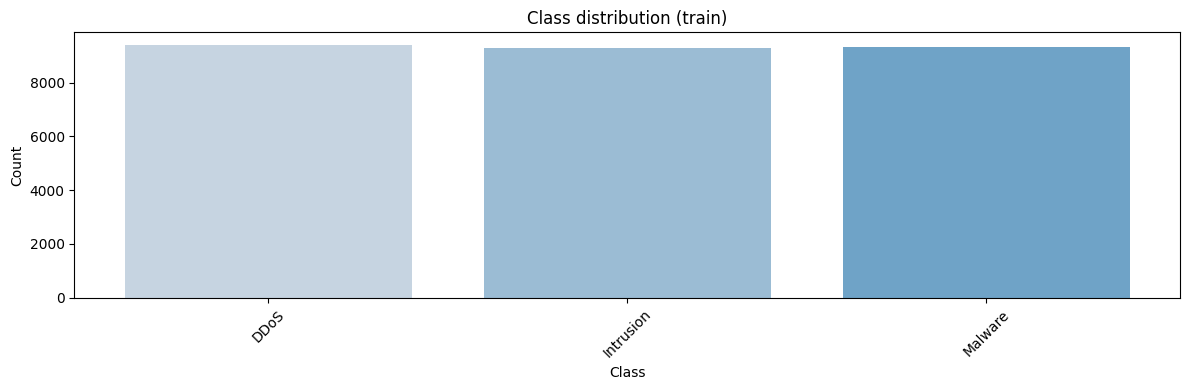

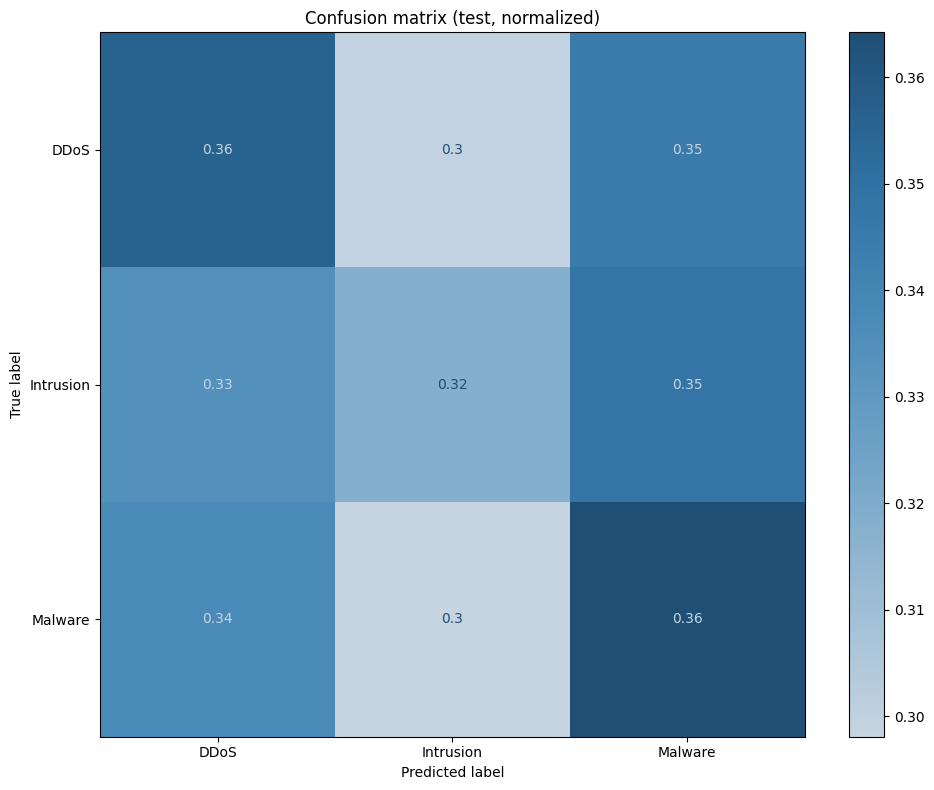

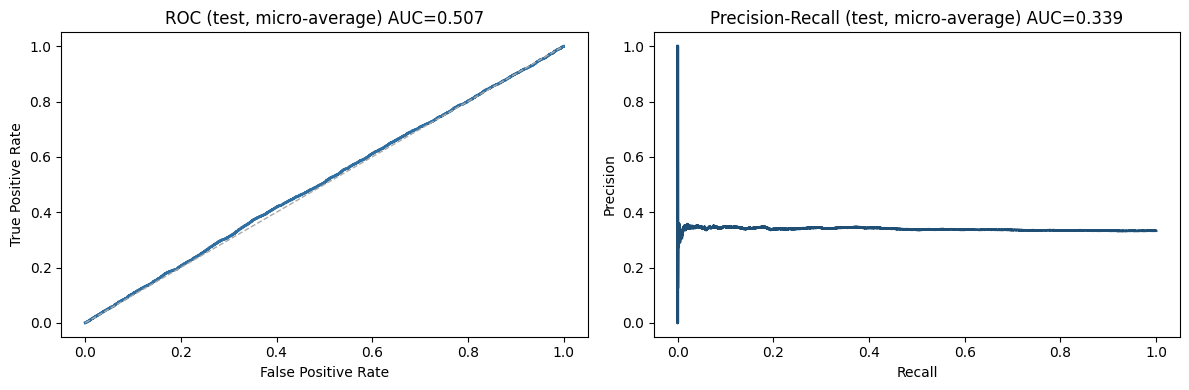

In [7]:
# Charts for this experiment (uses `color_pallete` from config/visualization.json)

from __future__ import annotations
import json
from pathlib import Path
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from cycler import cycler
from matplotlib.colors import LinearSegmentedColormap
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import auc, precision_recall_curve, roc_curve
from sklearn.preprocessing import label_binarize

VIZ_CONFIG_JSON = (REPO_ROOT / "config" / "visualization.json").resolve()

with VIZ_CONFIG_JSON.open("r", encoding="utf-8") as f:
    viz_cfg = json.load(f)

# Spelling per request: `color_pallete`
color_pallete: list[str] = [str(c) for c in viz_cfg["visualization"]["color_palette"]]

# Also publish a canonical constant name some notebooks use
COLOR_PALLETE = color_pallete

# Apply palette globally (affects most plots, incl. pandas)
mpl.rcParams["axes.prop_cycle"] = cycler(color=color_pallete)

# Use the "blue" portion for heatmaps (avoid the gray tail of the palette)
COLOR_CMAP = LinearSegmentedColormap.from_list("color_palette", color_pallete[:6])
print(f"Loaded color_pallete ({len(color_pallete)} colors) from {VIZ_CONFIG_JSON}")

# Ensure predictions exist (this cell should run standalone)
if "val_pred" not in globals():
    val_pred = clf.predict(X_val)
if "test_pred" not in globals():
    test_pred = clf.predict(X_test)

def _class_order(y_true, y_pred) -> list[str]:
    y_true = pd.Series(y_true, dtype="string")
    y_pred = pd.Series(y_pred, dtype="string")
    classes = pd.Index(y_true.unique()).append(pd.Index(y_pred.unique()))
    # stable, deterministic order
    return sorted(pd.Index(classes).dropna().unique().astype(str).tolist())

classes = _class_order(y_test, test_pred)

# --- 1) Class distribution (train) ---
train_counts = y_train.value_counts().reindex(classes, fill_value=0)
fig, ax = plt.subplots(figsize=(12, 4))
bar_colors = [color_pallete[i % len(color_pallete)] for i in range(len(train_counts))]
ax.bar(train_counts.index.astype(str), train_counts.values, color=bar_colors)
ax.set_title("Class distribution (train)")
ax.set_xlabel("Class")
ax.set_ylabel("Count")
ax.tick_params(axis="x", labelrotation=45)
plt.tight_layout()
plt.show()

# --- 2) Confusion matrix (test, normalized) ---
fig, ax = plt.subplots(figsize=(10, 8))
ConfusionMatrixDisplay.from_predictions(
    y_test,
    test_pred,
    labels=classes,
    normalize="true",
    cmap=COLOR_CMAP,
    ax=ax,
    colorbar=True,
)

ax.set_title("Confusion matrix (test, normalized)")
plt.tight_layout()
plt.show()

# --- 3) ROC + PR (micro-average) using decision_function ---
has_decision = hasattr(clf, "decision_function")

if not has_decision:
    print("Skipping ROC/PR: classifier has no decision_function().")
else:
    scores = clf.decision_function(X_test)
    y_true = pd.Series(y_test, dtype="string")

    # Binary case: decision_function returns (n_samples,)
    if np.ndim(scores) == 1:
        # pick a consistent positive class
        classes_bin = sorted(y_true.unique().astype(str).tolist())
        if len(classes_bin) != 2:
            print("Skipping ROC/PR: expected 2 classes for binary decision scores.")
        else:
            pos_label = classes_bin[1]
            y_bin = (y_true.astype(str) == pos_label).astype(int).to_numpy()
            fpr, tpr, _ = roc_curve(y_bin, scores)
            roc_auc = auc(fpr, tpr)
            prec, rec, _ = precision_recall_curve(y_bin, scores)
            pr_auc = auc(rec, prec)
            fig, axes = plt.subplots(1, 2, figsize=(12, 4))
            axes[0].plot(fpr, tpr, color=color_pallete[4], linewidth=2)
            axes[0].plot([0, 1], [0, 1], linestyle="--", color=color_pallete[7], linewidth=1)
            axes[0].set_title(f"ROC (test) AUC={roc_auc:.3f} (pos={pos_label})")
            axes[0].set_xlabel("False Positive Rate")
            axes[0].set_ylabel("True Positive Rate")
            axes[1].plot(rec, prec, color=color_pallete[5], linewidth=2)
            axes[1].set_title(f"Precision-Recall (test) AUC={pr_auc:.3f} (pos={pos_label})")
            axes[1].set_xlabel("Recall")
            axes[1].set_ylabel("Precision")
            plt.tight_layout()
            plt.show()
    else:
        # Multiclass: micro-average across all classes
        y_bin = label_binarize(y_true.astype(str), classes=classes)
        scores = np.asarray(scores)
        if scores.shape[1] != y_bin.shape[1]:
            print("Skipping ROC/PR: score columns do not match class binarization.")
        else:
            fpr, tpr, _ = roc_curve(y_bin.ravel(), scores.ravel())
            roc_auc = auc(fpr, tpr)
            prec, rec, _ = precision_recall_curve(y_bin.ravel(), scores.ravel())
            pr_auc = auc(rec, prec)
            fig, axes = plt.subplots(1, 2, figsize=(12, 4))
            axes[0].plot(fpr, tpr, color=color_pallete[4], linewidth=2)
            axes[0].plot([0, 1], [0, 1], linestyle="--", color=color_pallete[7], linewidth=1)
            axes[0].set_title(f"ROC (test, micro-average) AUC={roc_auc:.3f}")
            axes[0].set_xlabel("False Positive Rate")
            axes[0].set_ylabel("True Positive Rate")
            axes[1].plot(rec, prec, color=color_pallete[5], linewidth=2)
            axes[1].set_title(f"Precision-Recall (test, micro-average) AUC={pr_auc:.3f}")
            axes[1].set_xlabel("Recall")
            axes[1].set_ylabel("Precision")
            plt.tight_layout()
            plt.show()
